<a href="https://colab.research.google.com/github/anuragb1090/JH_Agriculture/blob/master/900_Model_JH_Agriculture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# %%time

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving 100_test.csv to 100_test.csv
Saving 100_train.csv to 100_train.csv
User uploaded file "100_test.csv" with length 44631332 bytes
User uploaded file "100_train.csv" with length 67460981 bytes
CPU times: user 23.2 s, sys: 2.28 s, total: 25.5 s
Wall time: 36min 25s


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
import xgboost as xgb

In [67]:
train = pd.read_csv('/content/100_train.csv')
test = pd.read_csv('/content/100_test.csv')

# sample_submission = pd.read_csv('/content/sample_submission_V9Inaty.csv.csv')
print('Train shape:{}'.format(train.shape))
print('Test shape:{}'.format(test.shape))

Train shape:(88858, 76)
Test shape:(59310, 76)


In [53]:
kf = KFold(n_splits=5, random_state=55)

xgb_params = {
      'objective' : 'multi:softmax'
    , 'booster' : 'gbtree'
    , 'eta' : 0.1
    , 'max_depth' : 6
    , 'subsample' : 0.8
    , 'colsample_bytree' : 0.8
    , 'eval_metric' : 'merror'
    , 'seed' : 67
    , 'num_class' : 3
}

X = train.copy()
y = train['Crop_Damage']
X.drop(['Crop_Damage', 'ID'], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


****************************************
Iteration #:1
[0]	dval-merror:0.160984
Will train until dval-merror hasn't improved in 200 rounds.
[50]	dval-merror:0.154625
[100]	dval-merror:0.1526
[150]	dval-merror:0.153444
[200]	dval-merror:0.152881
[250]	dval-merror:0.15305
[300]	dval-merror:0.152768
Stopping. Best iteration:
[110]	dval-merror:0.152318

****************************************
Iteration #:2
[0]	dval-merror:0.157776
Will train until dval-merror hasn't improved in 200 rounds.
[50]	dval-merror:0.152656
[100]	dval-merror:0.151474
[150]	dval-merror:0.151531
[200]	dval-merror:0.151699
[250]	dval-merror:0.151193
[300]	dval-merror:0.150968
[350]	dval-merror:0.151531
[400]	dval-merror:0.152543
[450]	dval-merror:0.152318
Stopping. Best iteration:
[288]	dval-merror:0.150461

****************************************
Iteration #:3
[0]	dval-merror:0.162559
Will train until dval-merror hasn't improved in 200 rounds.
[50]	dval-merror:0.15682
[100]	dval-merror:0.156876
[150]	dval-merror:0.

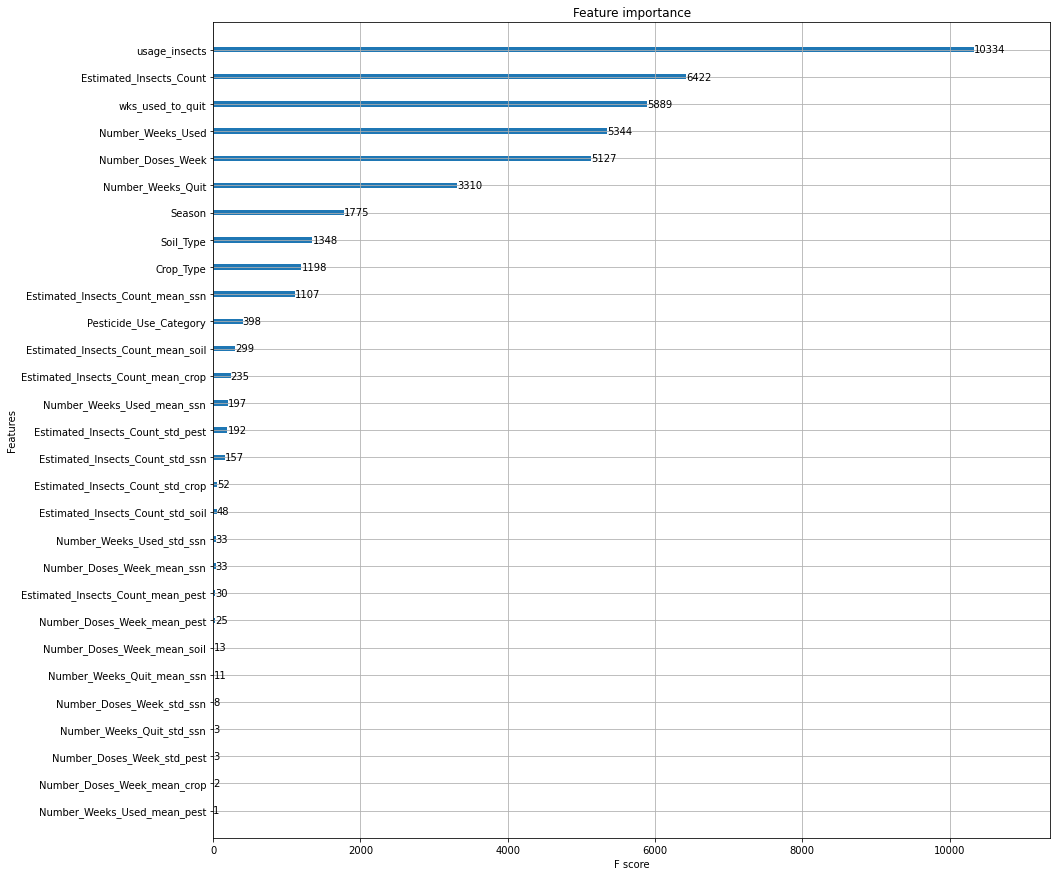

In [54]:
pred_X = pd.DataFrame()
pred_y = pd.DataFrame()

for idx, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
  print('**'*20)
  print('Iteration #:{}'.format(idx+1))

  X_tr, X_val, y_tr, y_val = X.iloc[tr_idx], X.iloc[val_idx],\
                              y.iloc[tr_idx], y.iloc[val_idx]

  dtrain = xgb.DMatrix(X_tr, label=y_tr)
  dval = xgb.DMatrix(X_val, label=y_val)  

  model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=1000,
                    evals=[(dval, 'dval')], early_stopping_rounds=200,
                    verbose_eval=50)
  
  pred_X = pd.concat([pred_X, X_val], axis=0)
  pred_y = pd.concat([pred_y, y_val], axis=0)
  
fig, ax = plt.subplots(figsize=(15,15))
xgb.plot_importance(model, ax=ax, height=0.2)

In [68]:
preds = pd.DataFrame(model.predict(xgb.DMatrix(pred_X)), columns=['predicted'])
preds = pd.concat([preds, pred_y], axis=1)
preds.columns.values[-1] = 'actual'
preds.head()

,predicted,actual
0,1.0,0.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [69]:
preds = pd.concat([train, preds], axis=1)
preds.to_csv('debug_07252020.csv', index=False)
preds.shape

(88858, 78)

In [70]:
accuracy_score(preds['predicted'], preds['actual'])

0.8571090954106552

In [72]:
tmp = test.copy()
tmp = tmp.drop(['ID', 'Crop_Damage'], axis=1)
submit = pd.DataFrame(model.predict(xgb.DMatrix(tmp)))
submit = pd.concat([test['ID'],submit], axis=1)
submit.columns.values[-1] = 'Crop_Damage'

print(submit.head())
print(submit['Crop_Damage'].value_counts())

submit.to_csv('agg_vars_xgb_07252020.csv', index=False)

          ID  Crop_Damage
0  F00000002          1.0
1  F00000007          1.0
2  F00000011          1.0
3  F00000013          1.0
4  F00000014          1.0
0.0    55974
1.0     3298
2.0       38
Name: Crop_Damage, dtype: int64
